In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import neurokit2 as nk
import matplotlib.pyplot as plt

# Global settings
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["figure.figsize"] = (20, 6)
plt.style.use('ggplot') # nicer plots
pd.set_option('display.max_columns', None)

# Data loading
df = pd.read_csv('output/empatica_inquisit_merged.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

/var/folders/4y/grqbq6j10592pmzzhgzbxdmr0000gn/T/ipykernel_69572/4282565010.py:16: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('output/empatica_inquisit_merged.csv')


In [2]:
df.head()

,acc_x,acc_y,acc_z,temp,eda,bvp,hr,datetime,unix_time,source,trialcode,response,intrusion,intrusion_nothink,intrusion_tnt
0,-8.00,46.00,48.00,26.45,0.03,61.93,85.00,2023-03-22 12:05:18.000000,1679486718.00,pp3-d1-1,NaN,0,0,NaN,NaN
1,-7.41,46.88,50.65,26.47,0.02,90.60,84.98,2023-03-22 12:05:18.015625,1679486718.02,pp3-d1-1,NaN,0,0,NaN,NaN
2,-6.00,46.00,47.00,26.48,0.02,100.07,84.95,2023-03-22 12:05:18.031250,1679486718.03,pp3-d1-1,NaN,0,0,NaN,NaN
3,-5.86,44.05,42.88,26.49,0.02,89.91,84.92,2023-03-22 12:05:18.046875,1679486718.05,pp3-d1-1,NaN,0,0,NaN,NaN
4,-7.00,44.00,43.00,26.50,0.02,64.68,84.88,2023-03-22 12:05:18.062500,1679486718.06,pp3-d1-1,NaN,0,0,NaN,NaN


## Visualising windows preceding + or - class labels

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# df['unix_time'] = pd.to_datetime(df['unix_time'], unit='s')  # Convert 'unix_time' to datetime format
# df = df.set_index('unix_time')

def get_segment_data(df, column_names):
    # Initialize dictionaries to store data for each label
    positive_data = {}
    negative_data = {}

    # Identify the indices where 'intrusion_tnt' is 1 and 0
    positive_indices = df[df['intrusion_tnt'] == 1].index
    negative_indices = df[df['intrusion_tnt'] == 0].index

    # For each column name
    for column in column_names:
        # Initialize lists to store data for each label
        positive_column_data = []
        negative_column_data = []

        # For each positive index, get the 8s preceding data
        for idx in positive_indices:
            temp_data = df.loc[idx - pd.Timedelta(seconds=8) + pd.Timedelta(seconds=1/64):idx, column]
            temp_data = temp_data.reset_index(drop=True)
            temp_data.name = f"{idx} - {column}"
            positive_column_data.append(temp_data)

        # For each negative index, get the 8s preceding data
        for idx in negative_indices:
            temp_data = df.loc[idx - pd.Timedelta(seconds=8) + pd.Timedelta(seconds=1/64):idx, column]
            temp_data = temp_data.reset_index(drop=True)
            temp_data.name = f"{idx} - {column}"
            negative_column_data.append(temp_data)

        # Concatenate the list of 8s of data into a DataFrame where each column is an 8s window of data
        positive_data[column] = pd.concat(positive_column_data, axis=1)
        negative_data[column] = pd.concat(negative_column_data, axis=1)

    return positive_data, negative_data

positive_data, negative_data = get_segment_data(df, ['bvp', 'eda']) # , 'temp', 'acc_x', 'acc_y', 'acc_z'

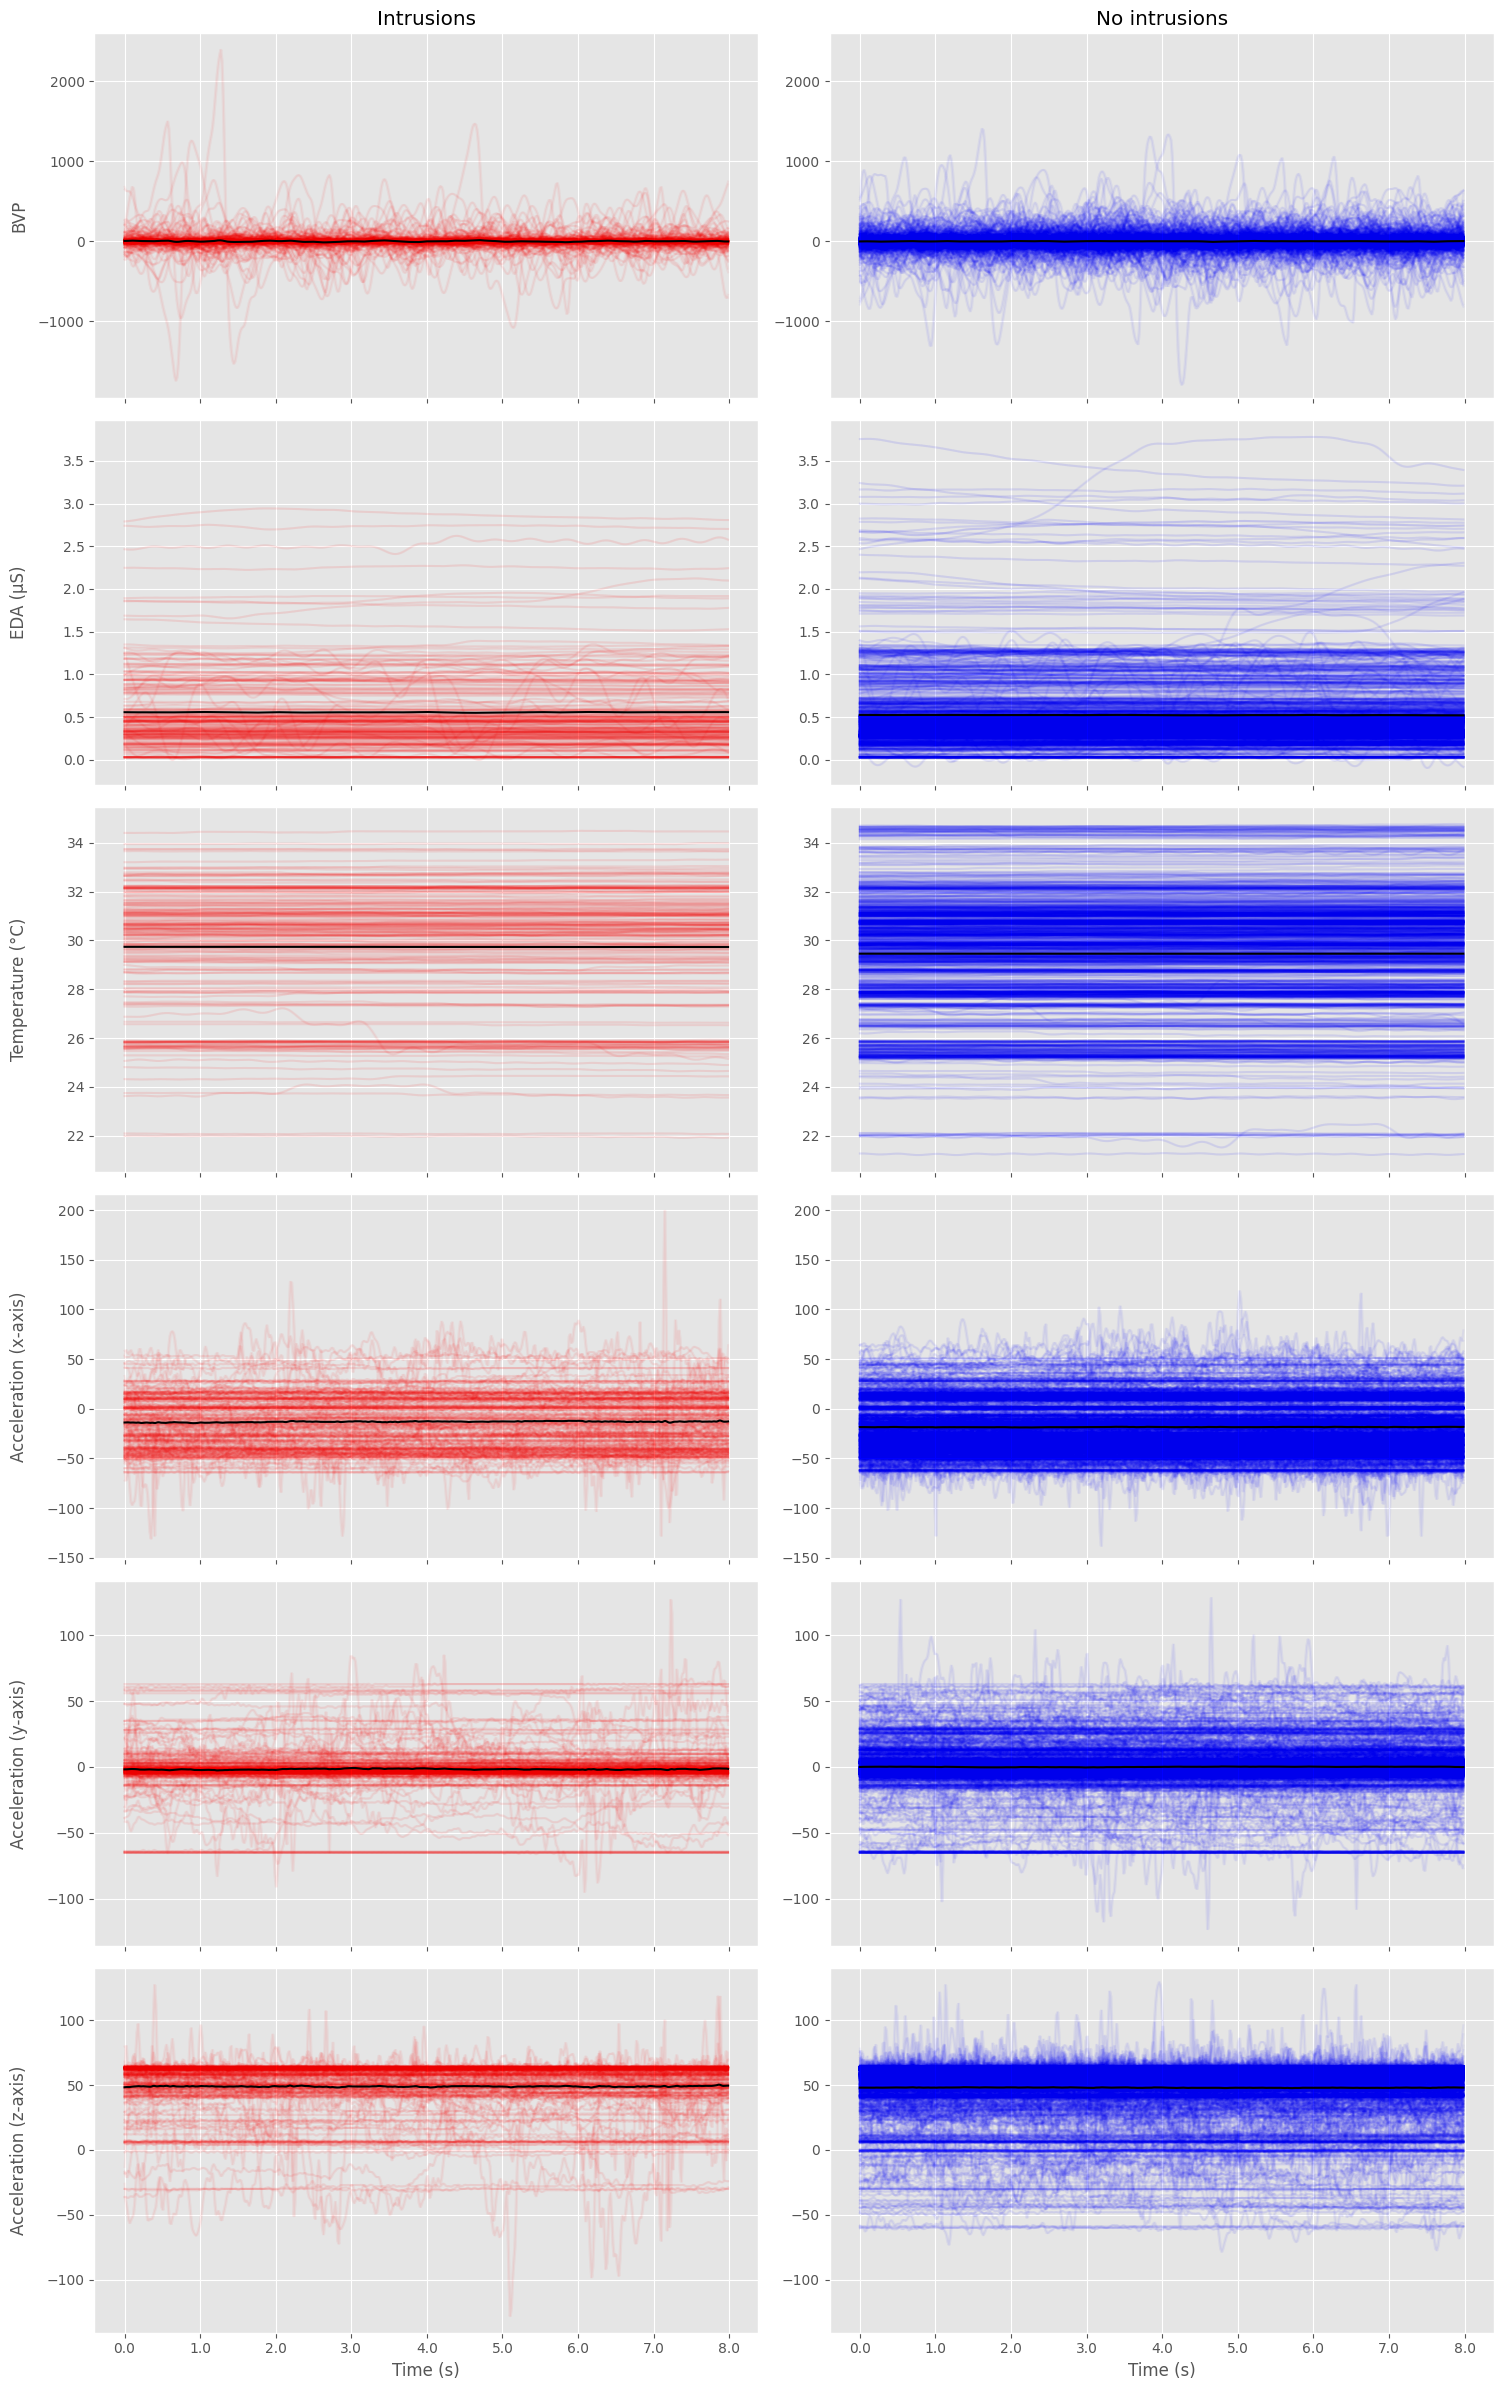

In [84]:
def plot_data_grid(positive_data, negative_data, save=False):
    # Create a grid of subplots with as many rows as there are keys in the data and 2 columns (one for each label)
    fig, axs = plt.subplots(len(positive_data.keys()), 2, sharex=True, figsize=(15, 4 * len(positive_data.keys())))

    # Create a time array based on the sampling rate
    time = np.arange(0, len(next(iter(positive_data.values())).iloc[:,0])) / 64

    # Create a dictionary to map old labels to new ones
    label_map = {
        'bvp': 'BVP',
        'eda': 'EDA (μS)',
        'temp': 'Temperature (°C)',
        'acc_x': 'Acceleration (x-axis)',
        'acc_y': 'Acceleration (y-axis)',
        'acc_z': 'Acceleration (z-axis)'
    }

    # For each key in the data
    for i, key in enumerate(positive_data.keys()):
        # Plot positive data
        for column in positive_data[key].columns:
            sns.lineplot(x=time, y=positive_data[key][column], alpha=0.05, color='red', ax=axs[i, 0])
        sns.lineplot(x=time, y=positive_data[key].mean(axis=1), color='black', ax=axs[i, 0])
        axs[i, 0].set_ylabel(label_map.get(key, key))  # Use the new label if it exists, otherwise use the old one
        axs[i, 0].yaxis.set_label_coords(-0.1,0.5)  # Set y-axis label coordinates
        axs[i, 0].set_xlabel('Time (s)')
        axs[i, 0].set_xticks(np.arange(min(time), max(time)+1, 1))  # Set x-axis ticks
        axs[i, 0].set_xticklabels(np.arange(min(time), max(time)+1, 1))  # Set x-axis tick labels

        # Plot negative data
        for column in negative_data[key].columns:
            sns.lineplot(x=time, y=negative_data[key][column], alpha=0.05, color='blue', ax=axs[i, 1])
        sns.lineplot(x=time, y=negative_data[key].mean(axis=1), color='black', ax=axs[i, 1])
        axs[i, 1].set_xlabel('Time (s)')
        axs[i, 1].set_ylabel('')  # Remove y-axis title for the second column
        axs[i, 1].set_xticks(np.arange(min(time), max(time)+1, 1))  # Set x-axis ticks
        axs[i, 1].set_xticklabels(np.arange(min(time), max(time)+1, 1))  # Set x-axis tick labels

        # Make y-axis the same for both plots in the row
        min_y = min(axs[i, 0].get_ylim()[0], axs[i, 1].get_ylim()[0])
        max_y = max(axs[i, 0].get_ylim()[1], axs[i, 1].get_ylim()[1])
        axs[i, 0].set_ylim(min_y, max_y)
        axs[i, 1].set_ylim(min_y, max_y)

    # Set column titles
    axs[0, 0].set_title('Intrusions')
    axs[0, 1].set_title('No intrusions')

    # Show the plot
    plt.tight_layout()
    if save:
        plt.savefig('output/pos_neg_classwindow_feature_values.png', dpi=300)
    plt.show()

plot_data_grid(positive_data, negative_data, save=True)

To calculate rolling windows for periods that are actually consecutive, you can use the rolling function in combination with the groupby function.

First, you need to create a new column that identifies each separate session. This could be done based on the datetime column. For example, you could consider that a new session starts when the time difference with the previous measurement is more than a certain threshold.

Once you have a column that identifies the sessions, you can group by this column and then apply the rolling function to each group. This will ensure that the rolling windows are calculated separately for each session.

In [3]:
# Create a column 'session_id' that identifies each session
df['session_id'] = (df['datetime'].diff() > pd.Timedelta(seconds=1/64)).cumsum()

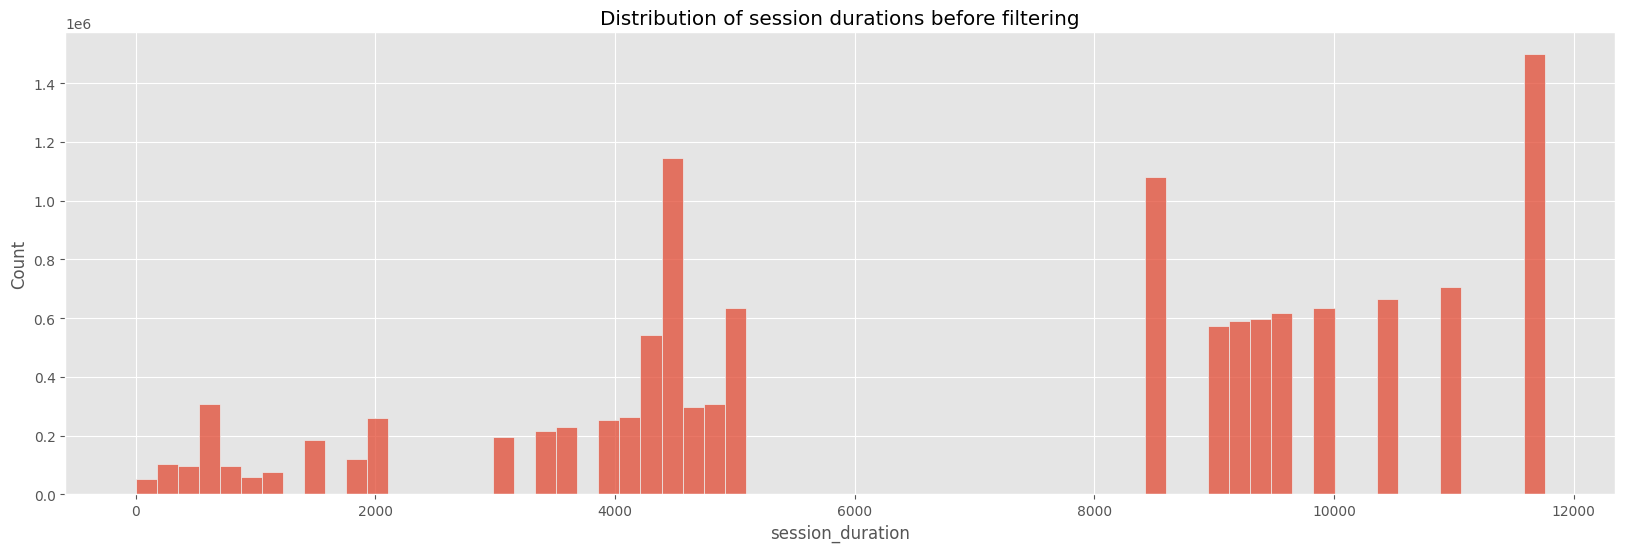

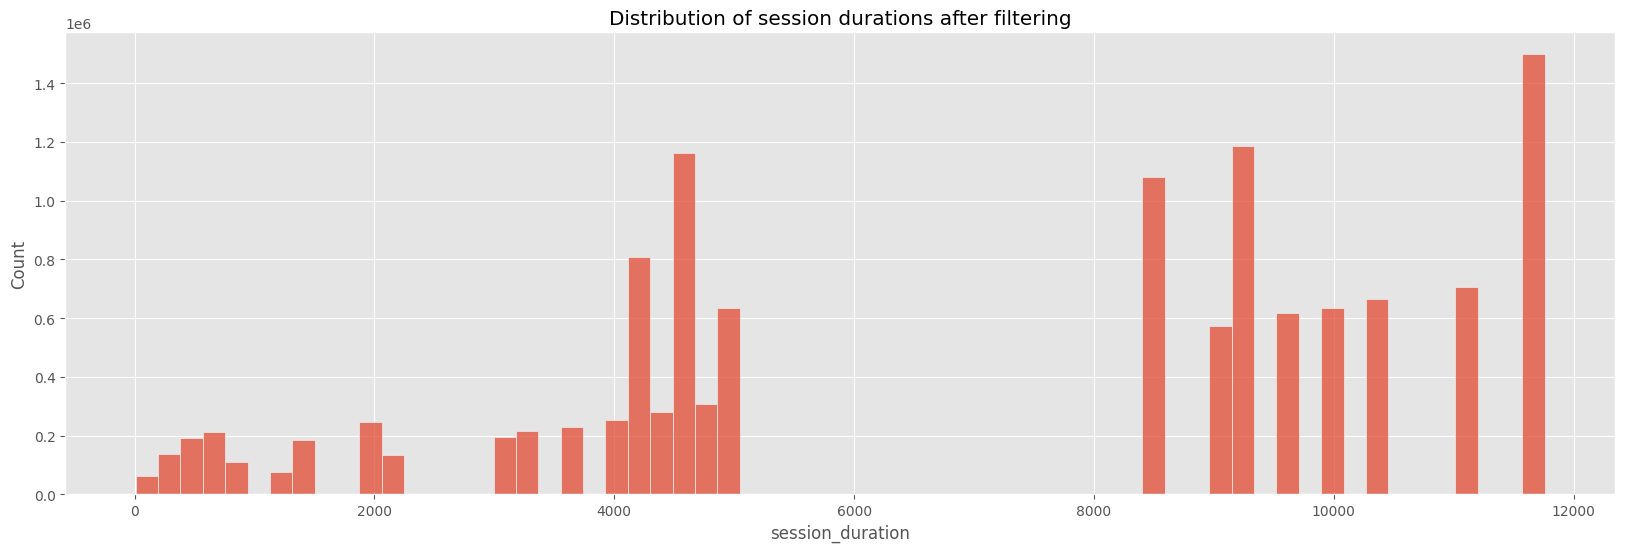

In [13]:
# Create a column 'session_duration' that indicates the duration of each session
df['session_duration'] = df.groupby('session_id')['datetime'].transform(lambda x: x.max() - x.min())

# Create a column 'session_start' that indicates the start of each session
df['session_start'] = df.groupby('session_id')['datetime'].transform('first')

# Create a column 'session_end' that indicates the end of each session
df['session_end'] = df.groupby('session_id')['datetime'].transform('last')

# Plot the distribution of session durations
sns.histplot(df['session_duration'].dt.total_seconds(), bins=len(df['session_id'].unique()))
plt.title('Distribution of session durations before filtering')
plt.show()

# Drop all sessions that are shorter than 8 seconds
print(f"Number of sessions before filtering: {len(df['session_id'].unique())}")
df = df[df['session_duration'].dt.total_seconds() > 8]
print(f"Number of sessions after filtering: {len(df['session_id'].unique())}"

# Plot the distribution of session durations
sns.histplot(df['session_duration'].dt.total_seconds(), bins=len(df['session_id'].unique()))
plt.title('Distribution of session durations after filtering')
plt.show()

In [4]:
s = 8 # Window size in seconds (8 seconds appears to be optimal based on theorising)
sr = 64
win = sr*s

# EDA
signals, info = nk.eda_process(df['eda'], sampling_rate=sr)
df['eda'] = signals['EDA_Clean'].values
df['eda_tonic'] = signals['EDA_Tonic'].values
df['eda_phasic'] = signals['EDA_Phasic'].values
df['eda_scr_onsets'] = signals['SCR_Onsets'].values
df['eda_scr_peaks'] = signals['SCR_Peaks'].values
df['eda_scr_height'] = signals['SCR_Height'].values
df['eda_scr_amplitude'] = signals['SCR_Amplitude'].values
df['eda_scr_risetime'] = signals['SCR_RiseTime'].values
df['eda_scr_recovery'] = signals['SCR_Recovery'].values

# Group by 'session_id'
temp = df.groupby('session_id')

# EDA
# Mean
df['eda_mean'] = temp['eda'].rolling(window=win).mean().reset_index(0, drop=True)

# Standard deviation
df['eda_std'] = temp['eda'].rolling(window=win).std().reset_index(0, drop=True)

# Minimum
df['eda_min'] = temp['eda'].rolling(window=win).min().reset_index(0, drop=True)

# Maximum
df['eda_max'] = temp['eda'].rolling(window=win).max().reset_index(0, drop=True)

# Skewness
df['eda_skew'] = temp['eda'].rolling(window=win).skew().reset_index(0, drop=True)

# Kurtosis
df['eda_kurt'] = temp['eda'].rolling(window=win).kurt().reset_index(0, drop=True)

# Domain-specific feature means
df['eda_tonic_mean'] = temp['eda_tonic'].rolling(window=win).mean().reset_index(0, drop=True)
df['eda_phasic_mean'] = temp['eda_phasic'].rolling(window=win).mean().reset_index(0, drop=True)
df['eda_scr_onsets_mean'] = temp['eda_scr_onsets'].rolling(window=win).mean().reset_index(0, drop=True)
df['eda_scr_peaks_mean'] = temp['eda_scr_peaks'].rolling(window=win).mean().reset_index(0, drop=True)
df['eda_scr_height_mean'] = temp['eda_scr_height'].rolling(window=win).mean().reset_index(0, drop=True)
df['eda_scr_amplitude_mean'] = temp['eda_scr_amplitude'].rolling(window=win).mean().reset_index(0, drop=True)
df['eda_scr_risetime_mean'] = temp['eda_scr_risetime'].rolling(window=win).mean().reset_index(0, drop=True)
df['eda_scr_recovery_mean'] = temp['eda_scr_recovery'].rolling(window=win).mean().reset_index(0, drop=True)

# ACCELEROMETER
# Mean
df['acc_x_mean'] = temp['acc_x'].rolling(window=win).mean().reset_index(0, drop=True)
df['acc_y_mean'] = temp['acc_y'].rolling(window=win).mean().reset_index(0, drop=True)
df['acc_z_mean'] = temp['acc_z'].rolling(window=win).mean().reset_index(0, drop=True)

# Standard deviation
df['acc_x_std'] = temp['acc_x'].rolling(window=win).std().reset_index(0, drop=True)
df['acc_y_std'] = temp['acc_y'].rolling(window=win).std().reset_index(0, drop=True)
df['acc_z_std'] = temp['acc_z'].rolling(window=win).std().reset_index(0, drop=True)

# Minimum
df['acc_x_min'] = temp['acc_x'].rolling(window=win).min().reset_index(0, drop=True)
df['acc_y_min'] = temp['acc_y'].rolling(window=win).min().reset_index(0, drop=True)
df['acc_z_min'] = temp['acc_z'].rolling(window=win).min().reset_index(0, drop=True)

# Maximum
df['acc_x_max'] = temp['acc_x'].rolling(window=win).max().reset_index(0, drop=True)
df['acc_y_max'] = temp['acc_y'].rolling(window=win).max().reset_index(0, drop=True)
df['acc_z_max'] = temp['acc_z'].rolling(window=win).max().reset_index(0, drop=True)

# Skewness
df['acc_x_skew'] = temp['acc_x'].rolling(window=win).skew().reset_index(0, drop=True)
df['acc_y_skew'] = temp['acc_y'].rolling(window=win).skew().reset_index(0, drop=True)
df['acc_z_skew'] = temp['acc_z'].rolling(window=win).skew().reset_index(0, drop=True)

# Kurtosis
df['acc_x_kurt'] = temp['acc_x'].rolling(window=win).kurt().reset_index(0, drop=True)
df['acc_y_kurt'] = temp['acc_y'].rolling(window=win).kurt().reset_index(0, drop=True)
df['acc_z_kurt'] = temp['acc_z'].rolling(window=win).kurt().reset_index(0, drop=True)

# TEMPERATURE
# Mean
df['temp_mean'] = temp['temp'].rolling(window=win).mean().reset_index(0, drop=True)

# Standard deviation
df['temp_std'] = temp['temp'].rolling(window=win).std().reset_index(0, drop=True)

# Minimum
df['temp_min'] = temp['temp'].rolling(window=win).min().reset_index(0, drop=True)

# Maximum
df['temp_max'] = temp['temp'].rolling(window=win).max().reset_index(0, drop=True)

# Skewness
df['temp_skew'] = temp['temp'].rolling(window=win).skew().reset_index(0, drop=True)

# Kurtosis
df['temp_kurt'] = temp['temp'].rolling(window=win).kurt().reset_index(0, drop=True)

# HR
# Mean
df['hr_mean'] = temp['hr'].rolling(window=win).mean().reset_index(0, drop=True)

# Standard deviation
df['hr_std'] = temp['hr'].rolling(window=win).std().reset_index(0, drop=True)

# Minimum
df['hr_min'] = temp['hr'].rolling(window=win).min().reset_index(0, drop=True)

# Maximum
df['hr_max'] = temp['hr'].rolling(window=win).max().reset_index(0, drop=True)

# Skewness
df['hr_skew'] = temp['hr'].rolling(window=win).skew().reset_index(0, drop=True)

# Kurtosis
df['hr_kurt'] = temp['hr'].rolling(window=win).kurt().reset_index(0, drop=True)


KeyboardInterrupt: 

In [4]:
# Create a dictionary that maps the original filenames to the new filenames
filename_map = {
    'd1 2': 'pp15_d1 2',
    'd1_1': 'pp13_d1_1',
    '1681713254_A03F6E': 'pp16_1681713254_A03F6E',
    '1681717717_A03F6E': 'pp17_1681717717_A03F6E',
    'd1_3': 'pp18_d1_3',
    'd2_1_1': 'pp17_d2_1_1',
    'd2_2': 'pp16_d2_2',
    'd1': 'pp19_d1',
    'd1_4': 'pp20_d1_4',
    'd2': 'pp18_d2',
    'd2_1': 'pp19_d2_1',
    'd2_4': 'pp20_d2_4'
}

# Update the 'source' column
df['source'] = df['source'].replace(filename_map)

In [5]:
df['participant'] = df['source'].str.extract('pp(\d{1,2})').astype(float)

df['participant'].unique()

array([ 3.,  2.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 13., 15., 16.,
       17., 18., 19., 20.])

In [8]:
df.iloc[500:550]

,acc_x,acc_y,acc_z,temp,eda,bvp,hr,datetime,unix_time,source,trialcode,response,intrusion,intrusion_nothink,intrusion_tnt,session_id,eda_tonic,eda_phasic,eda_scr_onsets,eda_scr_peaks,eda_scr_height,eda_scr_amplitude,eda_scr_risetime,eda_scr_recovery,eda_mean,eda_std,eda_min,eda_max,eda_skew,eda_kurt,eda_tonic_mean,eda_phasic_mean,eda_scr_onsets_mean,eda_scr_peaks_mean,eda_scr_height_mean,eda_scr_amplitude_mean,eda_scr_risetime_mean,eda_scr_recovery_mean,acc_x_mean,acc_y_mean,acc_z_mean,acc_x_std,acc_y_std,acc_z_std,acc_x_min,acc_y_min,acc_z_min,acc_x_max,acc_y_max,acc_z_max,acc_x_skew,acc_y_skew,acc_z_skew,acc_x_kurt,acc_y_kurt,acc_z_kurt,temp_mean,temp_std,temp_min,temp_max,temp_skew,temp_kurt,hr_mean,hr_std,hr_min,hr_max,hr_skew,hr_kurt,participant
500,-13.00,39.00,46.00,25.00,0.04,-64.11,69.15,2023-03-22 12:05:25.812500,1679486725.81,pp3-d1-1,NaN,0,0,NaN,NaN,0,0.09,-0.04,0,0,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00
501,-11.09,41.58,46.71,25.00,0.04,-76.05,69.17,2023-03-22 12:05:25.828125,1679486725.83,pp3-d1-1,NaN,0,0,NaN,NaN,0,0.09,-0.04,0,0,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00
502,-11.00,44.00,45.00,25.01,0.04,-96.18,69.18,2023-03-22 12:05:25.843750,1679486725.84,pp3-d1-1,NaN,0,0,NaN,NaN,0,0.09,-0.04,0,0,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00
503,-13.25,45.64,43.99,25.01,0.04,-117.02,69.20,2023-03-22 12:05:25.859375,1679486725.86,pp3-d1-1,NaN,0,0,NaN,NaN,0,0.09,-0.04,0,0,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00
504,-16.00,45.00,44.00,25.02,0.04,-129.39,69.21,2023-03-22 12:05:25.875000,1679486725.88,pp3-d1-1,NaN,0,0,NaN,NaN,0,0.09,-0.04,0,0,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00
505,-17.13,41.36,42.91,25.02,0.04,-127.29,69.22,2023-03-22 12:05:25.890625,1679486725.89,pp3-d1-1,NaN,0,0,NaN,NaN,0,0.09,-0.04,0,0,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00
506,-17.00,37.00,41.00,25.02,0.04,-111.55,69.24,2023-03-22 12:05:25.906250,1679486725.91,pp3-d1-1,NaN,0,0,NaN,NaN,0,0.09,-0.04,0,0,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00
507,-17.36,35.85,41.40,25.02,0.04,-90.46,69.25,2023-03-22 12:05:25.921875,1679486725.92,pp3-d1-1,NaN,0,0,NaN,NaN,0,0.09,-0.05,0,0,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00
508,-18.00,39.00,45.00,25.02,0.04,-76.39,69.27,2023-03-22 12:05:25.937500,1679486725.94,pp3-d1-1,NaN,0,0,NaN,NaN,0,0.09,-0.05,0,0,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00
509,-16.69,43.25,48.49,25.02,0.04,-80.40,69.28,2023-03-22 12:05:25.953125,1679486725.95,pp3-d1-1,NaN,0,0,NaN,NaN,0,0.09,-0.05,0,0,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [9]:
# Save the dataframe
# df.to_parquet('output/empatica_inquisit_merged_features.parquet', index=False)

# Only keep rows that dont have nan for intrusion_tnt 
df = df.dropna(subset=['intrusion_tnt'])

len(df)

# Save the dataframe
df.to_csv('output/combined_feature_engineered_tnt_only_win8.csv', index=False)

In [10]:
print(len(df))

2568
